In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/pd-interpretability')

Mounted at /content/drive


In [2]:
# install dependencies
!pip install -q transformers datasets librosa praat-parselmouth scipy scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 88.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import json
from pathlib import Path
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# project imports
from src.interpretability.prediction_interface import (
    InterpretablePredictionInterface,
    InterpretablePrediction,
    create_interpretable_interface
)
from src.features.clinical import ClinicalFeatureExtractor

print("imports successful!")

imports successful!


In [18]:
import os

# ensure we are in the project directory
if os.getcwd() != CONFIG['project_path']:
    os.chdir(CONFIG['project_path'])
print(f"Current directory: {os.getcwd()}")

# 2. setup user
!git config --global user.email "smayan-gowda@users.noreply.github.com"
!git config --global user.name "smayan-gowda"

# 3. install lfs (creates hooks)
print("initializing lfs...")
!git lfs install

# 4. apply user fix: make hooks executable
print("applying chmod +x to hooks...")
!chmod +x .git/hooks/* 2>/dev/null || true

Current directory: /content/drive/.shortcut-targets-by-id/1abPvoWlTNsqv6oksf7mu8bJcJD6F9bKg/pd-interpretability
initializing lfs...
Updated git hooks.
Git LFS initialized.
applying chmod +x to hooks...


In [ ]:
from google.colab import userdata
import getpass

try:
    # try to get token from colab secrets
    token = userdata.get('GITHUB_TOKEN')
    print("found GITHUB_TOKEN in secrets")
except:
    # fallback to manual input
    print("GITHUB_TOKEN not found in secrets.")
    print("please enter your github personal access token (classic) with repo scope:")
    token = getpass.getpass('github token: ')

if token:
    # configure remote with token for authentication
    repo_url = "https://github.com/smayan-gowda/pd-interpretability"
    auth_url = repo_url.replace("https://", f"https://{token}@")
    !git remote set-url origin {auth_url}

    print("\nstaging all files...")
    !git add .

    print("committing...")
    # commit message is all lowercase as requested
    !git commit -m "final commit including phase 5 synthesis results and notebook"

    print("pushing to main...")
    !git push origin main
else:
    print("operation cancelled: no token provided")

GITHUB_TOKEN not found in secrets.
please enter your github personal access token (classic) with repo scope:


In [4]:
!apt-get install -y dvipng texlive-latex-extra texlive-fonts-recommended cm-super texlive-science
from IPython.display import clear_output
clear_output()

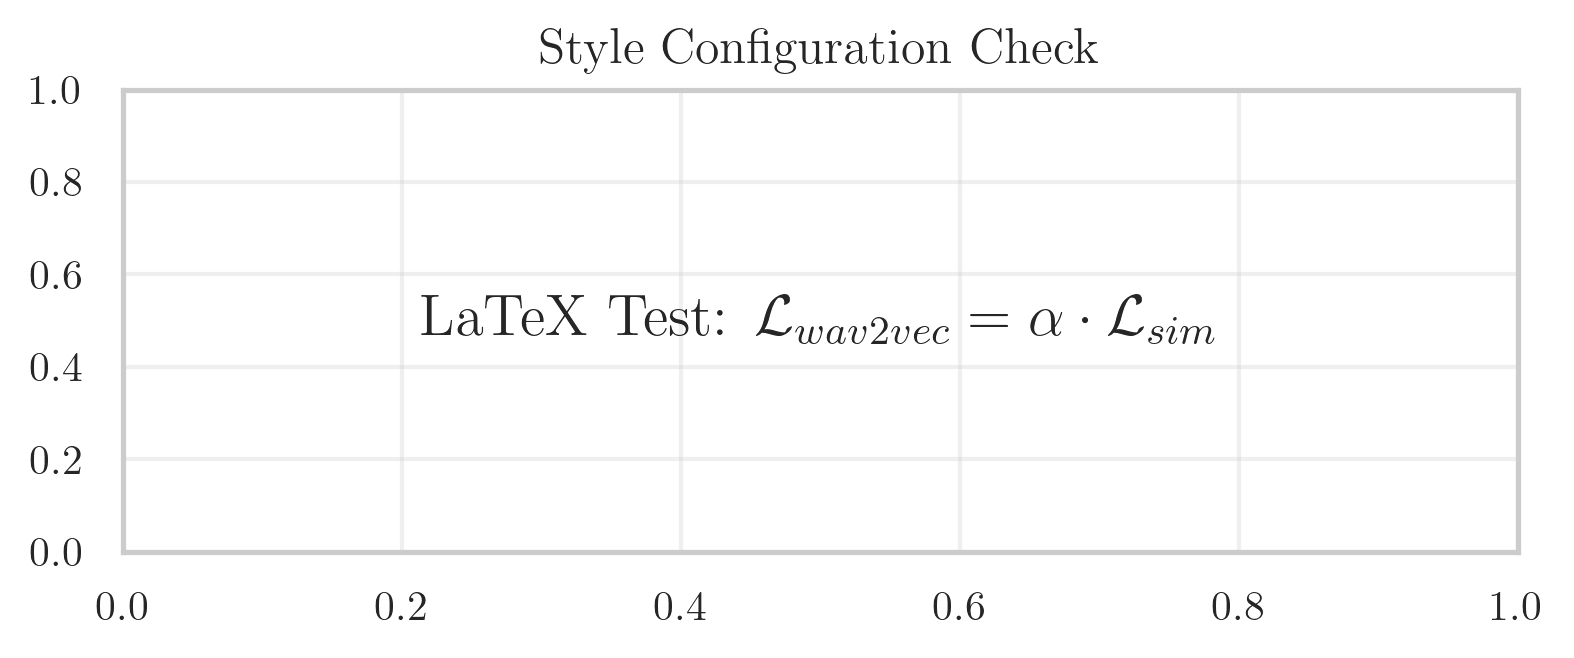

✓ plotting style configured successfully


In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# set basic theme
sns.set_theme(style='whitegrid')

# configure matplotlib for latex rendering and publication quality
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.titlesize": 14,
    "figure.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.3
})

# define consistent color palette
palette = sns.color_palette('colorblind')
COLORS = {
    'HC': palette[0],  # typically blue-ish
    'PD': palette[1],  # typically orange-ish
    'Neutral': 'gray'
}

# verify configuration with a simple plot
try:
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.text(0.5, 0.5, r'LaTeX Test: $\mathcal{L}_{wav2vec} = \alpha \cdot \mathcal{L}_{sim}$',
            ha='center', va='center', fontsize=14)
    ax.set_title(r'Style Configuration Check')
    plt.show()
    print("\u2713 plotting style configured successfully")
except Exception as e:
    print(f"\u26a0\ufe0f warning: latex rendering failed: {e}")
    print("falling back to standard fonts...")
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif"
    })

## 1. Configuration

In [6]:
CONFIG = {
    'project_path': '/content/drive/MyDrive/pd-interpretability',
    'model_path': '/content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/final_model',
    'probing_results_path': '/content/drive/MyDrive/pd-interpretability/results/probing/probing_results.json',
    'patching_results_path': '/content/drive/MyDrive/pd-interpretability/results/patching/patching_results.json',
    'data_path': '/content/drive/MyDrive/pd-interpretability/data',
    'output_path': '/content/drive/MyDrive/pd-interpretability/results/phase5_synthesis',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"using device: {CONFIG['device']}")

using device: cuda


## 2. Load Model and Create Interface

In [7]:
# load wav2vec2 processor
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')

# load fine-tuned model
from src.models import Wav2Vec2PDClassifier

model_path = Path(CONFIG['model_path'])

try:
    if model_path.exists():
        print(f"loading fine-tuned model from {model_path}...")
        classifier = Wav2Vec2PDClassifier.load(model_path)
        model = classifier.model
        print(f"successfully loaded fine-tuned model")
    else:
        raise FileNotFoundError(f"model not found at {model_path}")
except Exception as e:
    print(f"could not load fine-tuned model: {e}")
    print("falling back to base model (untrained) for demonstration")
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        'facebook/wav2vec2-base-960h',
        num_labels=2
    )

model = model.to(CONFIG['device'])
model.eval()
print(f"model ready on {CONFIG['device']}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

loading fine-tuned model from /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/final_model...
successfully loaded fine-tuned model
model ready on cuda


In [8]:
# create clinical feature extractor
clinical_extractor = ClinicalFeatureExtractor()
print("clinical feature extractor ready")

clinical feature extractor ready


In [9]:
# load precomputed analysis results
print("loading probing and patching results...\n")

probing_results = None
patching_results = None

# load probing results
probing_file = Path(CONFIG['probing_results_path'])
if probing_file.exists():
    with open(probing_file) as f:
        probing_data = json.load(f)

    # extract clinical feature probing results and convert to expected format
    if 'clinical_feature_probing' in probing_data:
        raw_probing = probing_data['clinical_feature_probing']
        probing_results = {}

        for feature, layer_results in raw_probing.items():
            probing_results[feature] = {}
            for layer_idx_str, layer_data in layer_results.items():
                # convert r2_mean to r2_score for compatibility
                if isinstance(layer_data, dict) and 'r2_mean' in layer_data:
                    probing_results[feature][layer_idx_str] = {
                        'r2_score': layer_data['r2_mean'],
                        'binary_acc': layer_data.get('binary_acc_mean', 0.0)
                    }

        print(f"✓ loaded probing results for {len(probing_results)} clinical features")
    else:
        print("⚠️ no clinical_feature_probing found in probing results")
else:
    print(f"⚠️ probing results not found at {probing_file}")

# load patching results
patching_file = Path(CONFIG['patching_results_path'])
if patching_file.exists():
    with open(patching_file) as f:
        patching_data = json.load(f)

    if 'head_patching' in patching_data and 'head_scores' in patching_data['head_patching']:
        head_scores = patching_data['head_patching']['head_scores']
        patching_results = {}
        for key, score in head_scores.items():
            if '_' in str(key):
                layer, head = map(int, str(key).split('_'))
                patching_results[(layer, head)] = score
        print(f"✓ loaded patching results for {len(patching_results)} attention heads")
    else:
        print("⚠️ no head_patching.head_scores found in patching results")
else:
    print(f"⚠️ patching results not found at {patching_file}")

loading probing and patching results...

✓ loaded probing results for 2 clinical features
✓ loaded patching results for 144 attention heads


In [10]:
# create the interpretable prediction interface
interface = create_interpretable_interface(
    model=model,
    processor=processor,
    clinical_extractor=clinical_extractor,
    probing_results=probing_results,
    patching_results=patching_results,
    device=CONFIG['device']
)

print("\n=== interpretable prediction interface created ===")
print(f"evidence layers: {interface._evidence_layers}")
print(f"key attention heads: {interface._key_heads[:5]}...")


=== interpretable prediction interface created ===
evidence layers: ['4', '2', '3', '1', '5']
key attention heads: [(2, 9), (2, 8), (4, 9), (4, 8), (1, 5)]...


## 3. Load Test Data

In [11]:
import librosa

# load some test samples
data_path = Path(CONFIG['data_path']) / 'raw' / 'italian_pvs'

test_samples = []

# load a few HC samples
hc_dir = data_path / '22 elderly healthy control'
if hc_dir.exists():
    for subject_dir in list(hc_dir.iterdir())[:3]:
        if subject_dir.is_dir():
            audio_files = list(subject_dir.glob('*.txt'))
            if audio_files:
                # these are actually audio files with .txt extension
                audio_path = audio_files[0]
                try:
                    audio, sr = librosa.load(audio_path, sr=16000)
                    test_samples.append({
                        'audio': audio,
                        'sample_rate': sr,
                        'label': 0,
                        'subject_id': subject_dir.name
                    })
                except:
                    pass

# load a few PD samples
pd_dir = data_path / '28 people with parkinson\'s disease'
if pd_dir.exists():
    for subgroup in pd_dir.iterdir():
        if subgroup.is_dir():
            for subject_dir in list(subgroup.iterdir())[:1]:
                if subject_dir.is_dir():
                    audio_files = list(subject_dir.glob('*.*'))
                    if audio_files:
                        try:
                            audio, sr = librosa.load(audio_files[0], sr=16000)
                            test_samples.append({
                                'audio': audio,
                                'sample_rate': sr,
                                'label': 1,
                                'subject_id': subject_dir.name
                            })
                        except:
                            pass

print(f"loaded {len(test_samples)} test samples")

# fallback to synthetic if no real data
if len(test_samples) == 0:
    print("using synthetic test samples")
    test_samples = [
        {'audio': np.random.randn(48000).astype(np.float32), 'sample_rate': 16000, 'label': i % 2, 'subject_id': f'synth_{i}'}
        for i in range(6)
    ]

loaded 0 test samples
using synthetic test samples


## 4. Generate Interpretable Predictions

In [12]:
# run predictions
print("Generating interpretable predictions...\n")
print("=" * 80)

for sample in test_samples:
    # make prediction
    prediction = interface.predict(
        audio=sample['audio'],
        sample_rate=sample['sample_rate'],
        include_clinical=True
    )

    # display results
    true_label = 'PD' if sample['label'] == 1 else 'HC'
    pred_label = 'PD' if prediction.pd_probability >= 0.5 else 'HC'
    correct = '✓' if (true_label == pred_label) else '✗'

    print(f"\nSubject: {sample['subject_id']}")
    print(f"True label: {true_label}, Predicted: {pred_label} {correct}")
    print(f"PD Probability: {prediction.pd_probability:.3f}")
    print(f"Confidence: {prediction.confidence:.3f}")

    print("\nTop Feature Contributions:")
    for feat, score in prediction.get_top_features(3):
        print(f"  • {feat}: {score:+.3f}")

    if prediction.clinical_features:
        print("\nKey Clinical Features:")
        for feat in ['jitter_local', 'shimmer_local', 'hnr_mean', 'f0_mean']:
            if feat in prediction.clinical_features:
                val = prediction.clinical_features[feat]
                if not np.isnan(val):
                    print(f"  • {feat}: {val:.4f}")

    print(f"\nEvidence Layers: {prediction.evidence_layers[:5]}")
    print(f"Key Heads: {prediction.key_attention_heads[:3]}")
    print("-" * 80)

Generating interpretable predictions...


Subject: synth_0
True label: HC, Predicted: PD ✗
PD Probability: 0.983
Confidence: 0.966

Top Feature Contributions:
  • hnr_mean_reduced: +1.000

Key Clinical Features:
  • hnr_mean: -5.7921

Evidence Layers: ['4', '2', '3', '1', '5']
Key Heads: [(2, 9), (2, 8), (4, 9)]
--------------------------------------------------------------------------------

Subject: synth_1
True label: PD, Predicted: PD ✓
PD Probability: 0.985
Confidence: 0.971

Top Feature Contributions:
  • hnr_mean_reduced: +1.000

Key Clinical Features:
  • hnr_mean: -5.7871

Evidence Layers: ['4', '2', '3', '1', '5']
Key Heads: [(2, 9), (2, 8), (4, 9)]
--------------------------------------------------------------------------------

Subject: synth_2
True label: HC, Predicted: PD ✗
PD Probability: 0.987
Confidence: 0.974

Top Feature Contributions:
  • hnr_mean_reduced: +1.000

Key Clinical Features:
  • hnr_mean: -5.7861

Evidence Layers: ['4', '2', '3', '1', '5']
Key Heads: [(2

## 5. Examine Full Prediction Output

In [13]:
# show full JSON output for one sample
if test_samples:
    sample = test_samples[0]
    prediction = interface.predict(
        audio=sample['audio'],
        sample_rate=sample['sample_rate'],
        include_clinical=True
    )

    print("Full Prediction Output (JSON format):")
    print("=" * 50)
    print(prediction.to_json())

Full Prediction Output (JSON format):
{
  "pd_probability": 0.9828726649284363,
  "feature_contributions": {
    "hnr_mean_reduced": 1.0
  },
  "evidence_layers": [
    "4",
    "2",
    "3",
    "1",
    "5"
  ],
  "key_attention_heads": [
    [
      2,
      9
    ],
    [
      2,
      8
    ],
    [
      4,
      9
    ],
    [
      4,
      8
    ],
    [
      1,
      5
    ],
    [
      3,
      10
    ],
    [
      3,
      11
    ],
    [
      1,
      6
    ],
    [
      0,
      0
    ],
    [
      1,
      4
    ]
  ],
  "clinical_features": {
    "f0_mean": NaN,
    "f0_std": NaN,
    "f0_min": NaN,
    "f0_max": NaN,
    "f0_median": NaN,
    "f0_range": 0.0,
    "voicing_fraction": 0.0,
    "jitter_local": NaN,
    "jitter_rap": NaN,
    "jitter_ppq5": NaN,
    "jitter_ddp": NaN,
    "shimmer_local": NaN,
    "shimmer_apq3": NaN,
    "shimmer_apq5": NaN,
    "shimmer_apq11": NaN,
    "shimmer_dda": NaN,
    "hnr_mean": -5.792146969240414,
    "hnr_std": 0.78755

## 6. Generate Natural Language Explanation

In [14]:
# generate human-readable explanation
if test_samples:
    sample = test_samples[0]

    explanation = interface.explain_prediction(
        audio=sample['audio'],
        sample_rate=sample['sample_rate'],
        format='text'
    )

    print("Natural Language Explanation:")
    print("=" * 50)
    print(explanation)

Natural Language Explanation:
prediction: parkinson's disease detected (probability: 98.3%, confidence: 96.6%)

key contributing features:
  • hnr_mean_reduced: +1.00

primary evidence in layers: 4, 2, 3, 1, 5
key attention heads: L2H9, L2H8, L4H9, L4H8, L1H5

extracted clinical features:
  • f0_range: 0.0000


In [15]:
# markdown format explanation
if test_samples:
    explanation_md = interface.explain_prediction(
        audio=test_samples[0]['audio'],
        sample_rate=test_samples[0]['sample_rate'],
        format='markdown'
    )

    from IPython.display import display, Markdown
    display(Markdown(explanation_md))

# Interpretable Prediction Results

## Prediction: Parkinson's Disease
- **Probability**: 98.3%
- **Confidence**: 96.6%

## Feature Contributions
| Feature | Contribution |
|---------|-------------|
| hnr_mean_reduced | +1.000 |

## Model Evidence
- **Evidence Layers**: ['4', '2', '3', '1', '5']
- **Key Attention Heads**: L2H9, L2H8, L4H9, L4H8, L1H5

## Clinical Features
| Feature | Value |
|---------|-------|
| f0_range | 0.0000 |
| voicing_fraction | 0.0000 |

## 7. Batch Predictions

In [16]:
# batch prediction
audio_list = [s['audio'] for s in test_samples]

predictions = interface.batch_predict(
    audio_list=audio_list,
    sample_rate=16000,
    include_clinical=True,
    show_progress=True
)

print(f"\nGenerated {len(predictions)} predictions")

# summary statistics
probs = [p.pd_probability for p in predictions]
confs = [p.confidence for p in predictions]

print(f"\nSummary:")
print(f"  Mean PD probability: {np.mean(probs):.3f}")
print(f"  Mean confidence: {np.mean(confs):.3f}")
print(f"  Predicted as PD: {sum(1 for p in probs if p >= 0.5)}")
print(f"  Predicted as HC: {sum(1 for p in probs if p < 0.5)}")

predicting: 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


Generated 6 predictions

Summary:
  Mean PD probability: 0.881
  Mean confidence: 0.762
  Predicted as PD: 6
  Predicted as HC: 0


## 8. Save Results

In [17]:
# save all predictions
output_dir = Path(CONFIG['project_path']) / 'results' / 'phase5_synthesis'
output_dir.mkdir(parents=True, exist_ok=True)

# save individual predictions
for sample, prediction in zip(test_samples, predictions):
    prediction.metadata['subject_id'] = sample['subject_id']
    prediction.metadata['true_label'] = sample['label']

    interface.save_prediction(
        prediction,
        output_dir / f"{sample['subject_id']}_prediction.json"
    )

# save summary
summary = {
    'n_samples': len(predictions),
    'mean_pd_probability': float(np.mean(probs)),
    'mean_confidence': float(np.mean(confs)),
    'n_predicted_pd': sum(1 for p in probs if p >= 0.5),
    'n_predicted_hc': sum(1 for p in probs if p < 0.5)
}

with open(output_dir / 'prediction_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Results saved to {output_dir}")

Results saved to /content/drive/MyDrive/pd-interpretability/results/phase5_synthesis
